In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!tar -xvf spark-3.0.1-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"]= "/content/spark-3.0.1-bin-hadoop2.7"
import findspark
findspark.init()

spark-3.0.1-bin-hadoop2.7/
spark-3.0.1-bin-hadoop2.7/RELEASE
spark-3.0.1-bin-hadoop2.7/examples/
spark-3.0.1-bin-hadoop2.7/examples/src/
spark-3.0.1-bin-hadoop2.7/examples/src/main/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/examples/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/examples/ml/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/examples/ml/FPGrowthExample.scala
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/examples/ml/GBTExample.scala
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/examples/ml/ALSExample.scala
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/examples/ml/KMeansExample.scala
spark-3.0.1-bin-hadoop2.7/example

In [2]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

spark = SparkSession.builder.getOrCreate()

In [3]:
spark.read.csv("MsNPC.csv", header = True).createOrReplaceTempView("npcs")
spark.read.csv("MsPlayer.csv", header = True).createOrReplaceTempView("players")
spark.read.csv("MsWeapon.csv", header = True).createOrReplaceTempView("weapons")
spark.read.csv("MsWeaponType.csv", header = True).createOrReplaceTempView("weapon_types")
spark.read.csv("TransactionDetail.csv", header = True).createOrReplaceTempView("transaction_details")
spark.read.csv("TransactionHeader.csv", header = True).createOrReplaceTempView("transaction_headers")

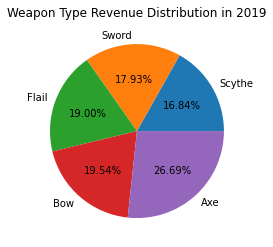

,weapontypename,revenue
0,Scythe,22833000.0
1,Sword,24300000.0
2,Flail,25748000.0
3,Bow,26484000.0
4,Axe,36184000.0


In [5]:
# a.	Show the percentage of weapon type sold for weapon type that is sold in 2019 using pie plot.

data = spark.sql("""
SELECT wt.weapontypename, sum(w.weaponprice * td.quantity) as revenue
FROM weapon_types wt
JOIN weapons w ON wt.weapontypeid = w.weapontypeid
JOIN transaction_details td ON w.weaponid = td.weaponid
JOIN transaction_headers th ON td.transactionid = th.transactionid
WHERE year(th.transactiondate) = 2019
GROUP BY wt.weapontypeid, wt.weapontypename
ORDER BY revenue
""").toPandas()

plt.pie(data["revenue"], labels=data["weapontypename"], autopct="%.2f%%")
plt.title("Weapon Type Revenue Distribution in 2019")
plt.show()

display(data)

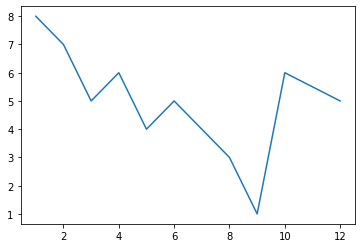

,count,MONTH
0,8,1
1,7,2
2,5,3
3,6,4
4,4,5
5,5,6
6,4,7
7,3,8
8,1,9
9,6,10


In [7]:
# b.	Show the total number of players who bought axe weapon type per month in 2019 using line plot. 
#    Multiple transaction within the same month will be counted as 1.

data = spark.sql("""
SELECT count(distinct th.playerid) as count, month(th.transactiondate) AS MONTH
FROM transaction_headers th 
JOIN transaction_details td ON th.transactionid = td.transactionid
JOIN weapons w ON td.weaponid = w.weaponid
JOIN weapon_types wt ON w.weapontypeid = wt.weapontypeid
WHERE YEAR(th.transactiondate) = 2019 AND wt.weapontypename = 'Axe'
GROUP BY MONTH(th.transactiondate)
ORDER BY MONTH
""").toPandas()

plt.plot(data["MONTH"], data["count"])
plt.show()

display(data)

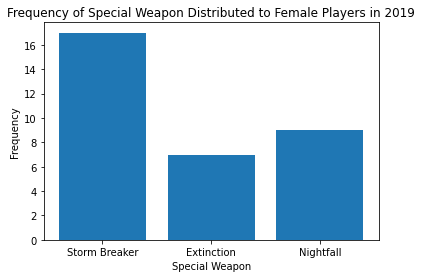

,SpecialWeapon,count
0,Storm Breaker,17
1,Extinction,7
2,Nightfall,9


In [8]:
# c.	Show the frequency of special weapon being distributed to female players in 2019 using bar plot. 
#     The player will receive special weapon if their monthly spending reached this following condition: 
#     Special Weapon	Monthly Spending
#     Storm Breaker	1000000 - 1499999
#     Nightfall	1500000 – 1999999
#     Extinction	> 2000000

data = spark.sql("""
SELECT 
SpecialWeapon,
COUNT(*) AS count
FROM(
  SELECT
    p.playerid,
    sum(w.weaponprice * td.quantity) as spending,
    case
      when sum(w.weaponprice * td.quantity) between 1000000 AND 1499999 THEN 'Storm Breaker'
      when sum(w.weaponprice * td.quantity) between 1500000 AND 1999999 THEN 'Nightfall'
      when sum(w.weaponprice * td.quantity) > 2000000 THEN 'Extinction'
    end as Specialweapon
    FROM players p
    JOIN transaction_headers th ON p.playerid = th.playerid
    JOIN transaction_details td ON th.transactionid = td.transactionid
    JOIN weapons w ON td.weaponid = w.weaponid
    WHERE p.playergender = 'Female' AND YEAR(th.transactiondate) = 2019
    GROUP BY p.playerid, month(th.transactiondate)
)
WHERE SpecialWeapon is not null
GROUP BY SpecialWeapon
""").toPandas()

plt.bar(data["SpecialWeapon"], data["count"])
plt.title("Frequency of Special Weapon Distributed to Female Players in 2019")
plt.xlabel("Special Weapon")
plt.ylabel("Frequency")
plt.show()

display(data)

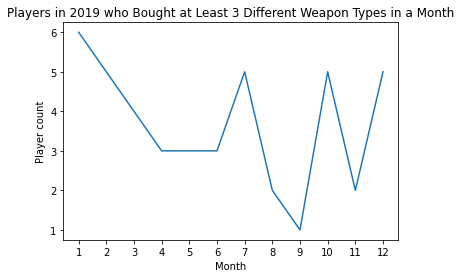

,count,month
0,6,1
1,5,2
2,4,3
3,3,4
4,3,5
5,3,6
6,5,7
7,2,8
8,1,9
9,5,10


In [9]:
# d.	Show total number of players per month in 2019 who bought at least 3
#     different weapon type in a month using line plot.

data = spark.sql("""
SELECT count(*) as count, month
FROM(
  SELECT th.playerid, month(th.transactiondate) as month
  FROM transaction_headers th
  JOIN transaction_details td ON th.transactionid = td.transactionid
  JOIN weapons w ON td.weaponid = w.weaponid
  WHERE YEAR(th.transactiondate) = 2019
  GROUP BY th.playerid, month(th.transactiondate)
  HAVING COUNT(DISTINCT w.weapontypeid) >= 3
)
GROUP BY month
ORDER BY month
""").toPandas()

plt.plot(data["month"], data["count"])
plt.title("Players in 2019 who Bought at Least 3 Different Weapon Types in a Month")
plt.xticks(range(1,13))
plt.xlabel("Month")
plt.ylabel("Player count")
plt.show()

display(data)

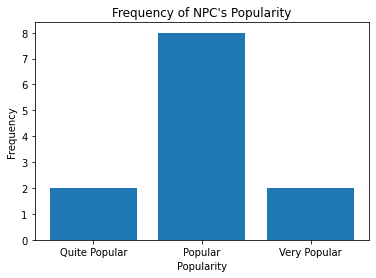

,count,popularity
0,2,Quite Popular
1,8,Popular
2,2,Very Popular


In [10]:
# e.	Show the frequency of NPC's popularity who has done at least transaction with 5 different player using bar plot. 
#     The popularity is determined based on the total income made by the NPC as follows:
#     Popularity	Total Income
#     Very Popular	>= 15,000,000
#     Popular	>= 7,500,000 – 14,999,999
#     Quite Popular	>= 2,500,000 – 7,499,999
#     Not Popular	< 2,500,000

data = spark.sql("""
SELECT count(*) as count, popularity
FROM(
  SELECT n.npcid,
  case
    when sum(td.quantity * w.weaponprice) >= 15000000 then 'Very Popular'
    when sum(td.quantity * w.weaponprice) between 7500000 AND 14999999 then 'Popular'
    when sum(td.quantity * w.weaponprice) between 2500000 AND 7499999 then 'Quite Popular'
    when sum(td.quantity * w.weaponprice) < 2500000 then 'Not Popular'
  end as popularity
  FROM npcs n 
  JOIN transaction_headers th ON n.npcid = th.npcid
  JOIN transaction_details td ON th.transactionid = td.transactionid
  JOIN weapons w ON td.weaponid = w.weaponid
  GROUP BY n.npciD
  having count(distinct th.playerid) >= 5 
)
group by popularity
""").toPandas()

plt.bar(data["popularity"], data["count"])
plt.title("Frequency of NPC's Popularity")
plt.xlabel("Popularity")
plt.ylabel("Frequency")
plt.show()

display(data)